In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 93.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you h

In [2]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from PIL import Image

from torchvision.models import resnet18, efficientnet_b1, vit_b_16
from torchvision.models import ResNet18_Weights, EfficientNet_B1_Weights, ViT_B_16_Weights
import torch.nn as nn
import os
from imutils import paths

dir = "/content/drive/MyDrive/SHBT261/Project/"
save_dir = os.path.join(dir, "figs")
os.makedirs(save_dir, exist_ok=True)

#### Loss Curve

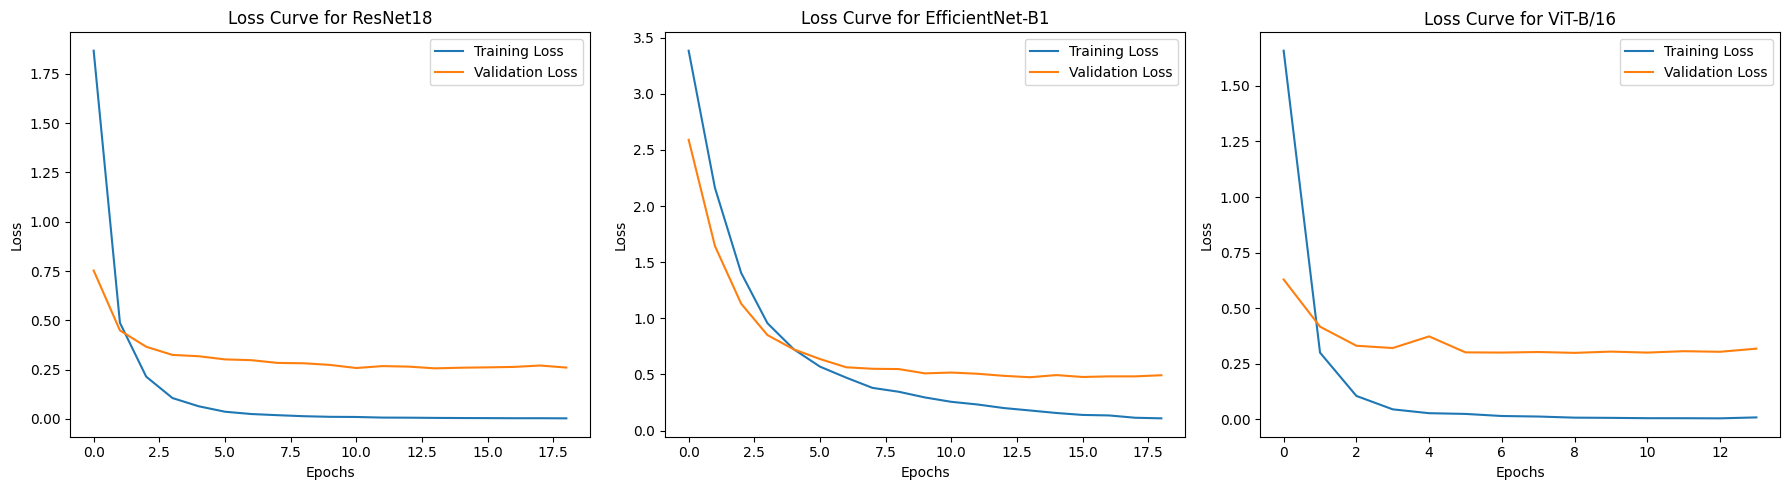

In [4]:
# Data for three models
models = ['ResNet18', 'EfficientNet-B1', 'ViT-B/16']
train_losses = {
    'ResNet18': [1.8673135369412495, 0.48760287523780016, 0.21450407949052216, 0.10598068464122297, 0.06421366821445136, 0.03662179655088892, 0.02492087565285163, 0.019034952671194556, 0.01384666681006887, 0.010769763813600515, 0.009956157473490261, 0.006853107157107041, 0.006351282564156701, 0.0052860289463666325, 0.0045903596263970805, 0.004185468004993443, 0.003598994005651813, 0.0036878958419603296, 0.003032319079760984],
    'EfficientNet-B1': [3.383086291565527, 2.162207642968553, 1.4035381756522953, 0.9562697244028117, 0.7246069772503, 0.569395133480491, 0.4712221046049984, 0.38023358083882325, 0.3456185410035691, 0.2948598125469502, 0.2560494246773168, 0.23228946004768936, 0.20056737343758152, 0.17889608360585282, 0.15658461602235105, 0.13928371751777582, 0.13480898791029447, 0.11423436259194808, 0.10890377303942726],
    'ViT-B/16': [1.6583165525703047, 0.3003628053275321, 0.10548493222675626, 0.045156390032159446, 0.027863668916121593, 0.02457961627792413, 0.015201601039396809, 0.012876331481761174, 0.007816241498807745, 0.006864052089294653, 0.005387085594669924, 0.005301015448406714, 0.0047038028249938805, 0.008940813295259795]
}
val_losses = {
    'ResNet18': [0.752640738373711, 0.44897610997457843, 0.3661050928810958, 0.3246592072435238, 0.31801506098697446, 0.3019408628275867, 0.2980250184711773, 0.28414599602032004, 0.2822551500000712, 0.27397690541733244, 0.25822046943890153, 0.2679860760356241, 0.2652356868606925, 0.25654511938812913, 0.259818754414992, 0.2615909503398037, 0.2637737644249759, 0.27087908246183906, 0.26050603379439646],
    'EfficientNet-B1': [2.589838536287416, 1.6439580580422772, 1.1298068100772511, 0.8505193948196376, 0.72343169196227, 0.6372330937242727, 0.5637906126895441, 0.5502867339301951, 0.5477240547057121, 0.5094990841529337, 0.516700776102173, 0.5059326698748929, 0.48754865240116824, 0.474903402629719, 0.4941482654502315, 0.4772659813021002, 0.4826771662715027, 0.4827076501560651, 0.4928132698237438],
    'ViT-B/16': [0.6293044557219826, 0.4170290920683133, 0.3312564087078868, 0.3209037651435205, 0.37338388659712357, 0.3014512621953557, 0.300573994944905, 0.3030518855550505, 0.2992294463236028, 0.30491226451462866, 0.3004576507068816, 0.30673557268126583, 0.304066559846317, 0.3181899337358372]
}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for each model
for i, model in enumerate(models):
    axs[i].plot(train_losses[model], label='Training Loss')
    axs[i].plot(val_losses[model], label='Validation Loss')
    axs[i].set_title(f'Loss Curve for {model}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "losscurve.png"), dpi=300)
plt.show()

##### Resnet Loss

In [5]:
# sgd, 128
train_loss_sgd_128 = [4.07025844642913, 3.197886000585658, 2.8217555990176715, 2.5363136889729216, 2.2872415945711704, 2.066807265338995, 1.8703399796708104, 1.699777291081361, 1.55027482762047, 1.412415916240924, 1.3078817413368709, 1.2012544579469018, 1.113515807939247, 1.037134944577989, 0.9705547378480522, 0.9119743693705231, 0.8597540088683715, 0.8056169116043601, 0.7609561713841491, 0.7171369421900192]
val_loss_sgd_128 = [3.4034270123219525, 2.930002694855088, 2.612875326437884, 2.34685858127342, 2.1226977327818513, 1.9095080634965325, 1.7466809910746397, 1.571224583825025, 1.4630434165169384, 1.3366781952926823, 1.2352104822428362, 1.154809074834012, 1.0711895851861863, 1.0089405758589642, 0.9517920731399466, 0.9096754236338509, 0.8793815551998062, 0.8442553183816361, 0.7938542459417598, 0.7571369805094283]

# sgd, 64
train_loss_sgd_64 = [4.190684928231355, 3.3932656111168384, 3.061275418460732, 2.8086366870543444, 2.5861659410775992, 2.3869025792829017, 2.2419469055029424, 2.1065122311342575, 1.9965972521739679, 1.8746899366771372, 1.7819975956295422, 1.6957508592536494, 1.5994258168186128, 1.525358692967242, 1.4611749207190268, 1.4029315420534236, 1.3535046904675556, 1.289945840717795, 1.240813016194636, 1.1894817507759696]
val_loss_sgd_64 = [3.6201695952730426, 3.1916309347899827, 2.914096781368812, 2.692974354997392, 2.505856829304849, 2.340563744077668, 2.253841036841983, 2.1216573165858397, 2.031791552969937, 1.9401016044909687, 1.8496054826610466, 1.777297354513599, 1.7279761405218215, 1.6606503466856644, 1.607607657458925, 1.5847703471161803, 1.551420841898237, 1.5094109689401958, 1.4643112036489672, 1.457246390539014]

# adam, 128
train_loss_adam_128 = [1.8673135369412495, 0.48760287523780016, 0.21450407949052216, 0.10598068464122297, 0.06421366821445136, 0.03662179655088892, 0.02492087565285163, 0.019034952671194556, 0.01384666681006887, 0.010769763813600515, 0.009956157473490261, 0.006853107157107041, 0.006351282564156701, 0.0052860289463666325, 0.0045903596263970805, 0.004185468004993443, 0.003598994005651813, 0.0036878958419603296, 0.003032319079760984]
val_loss_adam_128 = [0.752640738373711, 0.44897610997457843, 0.3661050928810958, 0.3246592072435238, 0.31801506098697446, 0.3019408628275867, 0.2980250184711773, 0.28414599602032004, 0.2822551500000712, 0.27397690541733244, 0.25822046943890153, 0.2679860760356241, 0.2652356868606925, 0.25654511938812913, 0.259818754414992, 0.2615909503398037, 0.2637737644249759, 0.27087908246183906, 0.26050603379439646]

# adam, 64
train_loss_adam_64 = [2.5484512973691493, 1.170075642047752, 0.7030302795383538, 0.43238870626802833, 0.2648413110540978, 0.1722703544460096, 0.11204746471791258, 0.07562059320836999, 0.055122831344074495, 0.04556197137015961, 0.03590644878195284, 0.02664729621888272, 0.024147783156264147, 0.02094882637355584, 0.017407454602100126, 0.01616345323860233]
val_loss_adam_64= [1.5892285291683472, 1.1720018527841056, 1.0060656579775011, 0.9528633323133266, 0.905150246510308, 0.8758576932590678, 0.8650142388409733, 0.8554689572886571, 0.8488197984050863, 0.8568118091003136, 0.8413753965483283, 0.84894708828992, 0.8536220067473966, 0.8436459006252377, 0.8414244836742794, 0.8800443795419508]

In [ ]:
train_losses = [
    train_loss_sgd_128,
    train_loss_sgd_64,
    train_loss_adam_128,
    train_loss_adam_64
]

val_losses = [
    val_loss_sgd_128,
    val_loss_sgd_64,
    val_loss_adam_128,
    val_loss_adam_64
]

titles = [
    "Loss Curve for ResNet18 with SGD (Image Size 128)",
    "Loss Curve for ResNet18 with SGD (Image Size 64)",
    "Loss Curve for ResNet18 with Adam (Image Size 128)",
    "Loss Curve for ResNet18 with Adam (Image Size 64)"
]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(4):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    ax.plot(train_losses[i], label="Train Loss")
    ax.plot(val_losses[i], label="Val Loss")
    ax.set_title(titles[i])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(dir, "resnet_losscurve.png"), dpi=300)
plt.show()

#### Grad-CAM

In [9]:
# Load models
def load_model(model_name, num_classes, weight_path):
    if model_name == "ResNet18":
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "EfficientNetB1":
        model = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "vit_b_16":
        model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:
        raise ValueError("Unknown model name")

    ckpt = torch.load(weight_path)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()
    return model

num_classes = 101
resnet_model = load_model("ResNet18", num_classes, os.path.join(dir, "outputs/resnet_results/best_ResNet18_opt-adam_img-128.pth"))
effnet_model = load_model("EfficientNetB1", num_classes, os.path.join(dir, "outputs/efficientnet_results/best_EfficientNetB1_opt-adam_img-128.pth"))
vit_model = load_model("vit_b_16", num_classes, os.path.join(dir, "outputs/vit_results/best_ViT_B_16_opt-adam_img-128.pth"))

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load sample images
crayfish_dir = os.path.join(dir, "dataset/caltech-101/crayfish")
image_paths = list(paths.list_images(crayfish_dir))
random.shuffle(image_paths)
selected_imgs = image_paths[:4]

# Grad-CAM
def get_cam_image(model, cam_extractor, img_tensor, orig_img):
    img_tensor = img_tensor.unsqueeze(0)
    out = model(img_tensor)
    pred_class = out.squeeze(0).argmax().item()
    activation_map = cam_extractor(pred_class, out)[0].squeeze(0).cpu()

    result = overlay_mask(orig_img.convert("RGB"), transforms.ToPILImage()(activation_map), alpha=0.5)
    return result

# Set Grad-CAM last conventional layer
resnet_cam = SmoothGradCAMpp(resnet_model, target_layer="layer4")
effnet_cam = SmoothGradCAMpp(effnet_model, target_layer="features[-1]")
vit_cam = SmoothGradCAMpp(vit_model, target_layer="encoder.layers[-1].ln_1")

# Visualization
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i, img_path in enumerate(selected_imgs):
    orig = Image.open(img_path).convert("RGB")
    img_tensor = transform(orig)

    # Original Image
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    # ResNet18 Grad-CAM
    res_img = get_cam_image(resnet_model, resnet_cam, img_tensor, orig)
    axes[i, 1].imshow(res_img)
    axes[i, 1].set_title("ResNet18")
    axes[i, 1].axis("off")

    # EfficientNet-B1 Grad-CAM
    eff_img = get_cam_image(effnet_model, effnet_cam, img_tensor, orig)
    axes[i, 2].imshow(eff_img)
    axes[i, 2].set_title("EfficientNet-B1")
    axes[i, 2].axis("off")

    # ViT-B-16 Grad-CAM
    vit_img = get_cam_image(vit_model, vit_cam, img_tensor, orig)
    axes[i, 3].imshow(vit_img)
    axes[i, 3].set_title("ViT-B-16")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(dir, "gradcam.png"), dpi=300)
plt.show()

RuntimeError: Error(s) in loading state_dict for VisionTransformer:
	size mismatch for encoder.pos_embedding: copying a param with shape torch.Size([1, 65, 768]) from checkpoint, the shape in current model is torch.Size([1, 197, 768]).